In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import subprocess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm.notebook import tqdm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# На случай, если нужно будет быстро скачать файл с диска
def upload_file_from_gdrive(gdrive_file_id, outfile) -> None:
    """
    Скачивает файл из Google Drive по ID.
    gdrive_file_id -- id файла на гугл-диске.
    outfile -- путь до файла
    """
    
    upload_cmd = (
        "wget --load-cookies /tmp/cookies.txt"
        " \"https://docs.google.com/uc?export=download&confirm=$("
        " wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies"
        f" --no-check-certificate 'https://docs.google.com/uc?export=download&id={gdrive_file_id}'"
        f" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\\1\\n/p')&id={gdrive_file_id}\" "
        f" -O {outfile} && rm -rf /tmp/cookies.txt"
    )
    subprocess.check_call(upload_cmd, shell=True)

def upload_file(link, outfile):
    gdrive_file_id = link.split('/')[-2]
    upload_file_from_gdrive(gdrive_file_id, outfile)

In [30]:
def get_invitro_data():
    link = "https://drive.google.com/file/d/1MT7jusUxg4fmG-3htm_15koe1MzJnLPd/view?usp=sharing"
    path = "invitro_train.csv"
    upload_file(link, path)

    invitro_data = pd.read_csv("invitro_train.csv", sep=',', parse_dates=[-1])
    invitro_data.loc[invitro_data['Значение'] == 'ОБНАРУЖ.', 'Значение'] = 'ОБНАРУЖ'
    invitro_data.loc[invitro_data['Значение'] == 'Detected', 'Значение'] = 'ОБНАРУЖ'
    invitro_data.loc[invitro_data['Значение'] != 'ОБНАРУЖ', 'Значение'] = 'НЕ ОБНАР'

    invitro_data['ОБНАРУЖ'] = (invitro_data['Значение'] == 'ОБНАРУЖ').astype(int)
    invitro_data['НЕ ОБНАР'] = (invitro_data['Значение'] == 'НЕ ОБНАР').astype(int)
    invitro_data['Количество тестов'] = invitro_data['ОБНАРУЖ'] + invitro_data['НЕ ОБНАР']
    invitro_data['Доля полож.'] = invitro_data['ОБНАРУЖ'] / invitro_data['Количество тестов'] * 100

    del invitro_data['Значение'], invitro_data['ОБНАРУЖ'], invitro_data['НЕ ОБНАР']

    return invitro_data


def get_times_data():
    link = "https://drive.google.com/file/d/1DvFIShPsm8W3kO_mN6ue0mJTQCpUdo1a/view?usp=sharing"
    path = "times.csv"
    upload_file(link, path)

    times_data = pd.read_csv(path)
    times_data = times_data.dropna()
    del times_data["регион"], times_data["время"]
    times_data = times_data.rename(columns={"Регион из инвитро": "Регион"})

    return times_data 


def get_updated_invitro_data():
    invitro_data = get_invitro_data()
    times_data = get_times_data()

    invitro_data_new = invitro_data.join(times_data.set_index("Регион"), on="Регион")
    invitro_data_new["Дата"] = invitro_data_new["Дата взятия"] \
        + pd.to_timedelta(invitro_data_new["Разница с Москвой"].values, 'h')

    del invitro_data_new["Разница с Москвой"], invitro_data_new["Дата взятия"], invitro_data_new["Код теста"]

    return invitro_data_new

In [31]:
invitro_data_new = get_updated_invitro_data()
invitro_data_new.head()

,Имя теста,Регион,Количество тестов,Доля полож.,Дата
0,Borrelia burgdorferi s.l (кач) ДНК,Челябинская обл,1,100.0,2019-05-25 08:02:00
1,Borrelia burgdorferi s.l (кач) ДНК,Челябинская обл,1,100.0,2019-05-27 11:04:00
2,Вирус клещевого энцефалита(кач) РНК,Челябинская обл,1,0.0,2019-05-27 11:04:00
3,Borrelia burgdorferi s.l (кач) ДНК,Челябинская обл,1,100.0,2019-05-27 11:14:00
4,Вирус клещевого энцефалита(кач) РНК,Челябинская обл,1,0.0,2019-05-27 11:14:00


In [32]:
def get_features_data():

    link = "https://drive.google.com/file/d/1I7WqtOkFE7_ahdJGqpPSyut60dRJgW7d/view?usp=sharing"
    path = "features.csv"
    upload_file(link, path)

    features = pd.read_csv(path)
    features = features.dropna()

    features_regions = np.array(sorted(features['Регион_БД_Инвитро']))
    invitro_regions = np.array(sorted(invitro_data_new['Регион'].unique()))
    bad = features_regions != invitro_regions
    for region_bad, region_good in zip(features_regions[bad], invitro_regions[bad]):
        features.loc[features['Регион_БД_Инвитро'] == region_bad, 'Регион_БД_Инвитро'] = region_good

    features = features.rename(columns={'Регион_БД_Инвитро': 'Регион'}).set_index('Регион')
    return features

In [33]:
features = get_features_data()
features.head()

,Регион_Длинное название,Регион_краткое название,Столица региона,Фед.Округ,Разница со временем по мск,Зарплата_2018,Зарплата_2019,Зарплата_2020,Признак эндемичности,Доступность ПЦР-диагностики,Население региона,Доля городского населения в общей численности населения на 1 января 2020 г.
Регион,,,,,,,,,,,,
Еврейская АО,Еврейская автономная область,Еврейская авт.обл.,Биробиджан,ДВФО,7,85631,94856,102843,да,388.9,158381,68.7
Приморский край,Приморский край,Приморский край,Владивосток,ДВФО,7,40740,43896,47172,да,255.4,1895868,70.9
Сахалинская обл,Сахалинская область,Сахалинская обл.,Южно-Сахалинск,ДВФО,8,42315,47234,52430,да,696.4,488257,85.0
Хабаровский край,Хабаровский край,Хабаровский край,Хабаровск,ДВФО,7,73896,80448,85623,да,471.3,1315643,82.1
Забайкальский край,Забайкальский край,Забайкальский край,Чита,ДВФО,6,51667,56437,60358,да,554.3,1059700,68.2


In [34]:
features['Фед.Округ'].unique()

array(['ДВФО', 'ПФО', 'СЗФО', 'СКФО', 'СФО', 'УФО', 'ЦФО', 'ЮФО'],
      dtype=object)

In [35]:
features[features['Фед.Округ'] == 'УФО'].index

Index(['Курганская обл', 'Свердловская обл', 'Тюменская обл ',
       'Ханты-Мансийский АО', 'Челябинская обл ', 'Ямало-Ненецкий АО'],
      dtype='object', name='Регион')

In [36]:
data_all = invitro_data_new.join(features, on='Регион')

In [37]:
stat_numbers = invitro_data_new.groupby(['Регион', 'Имя теста']).count()['Количество тестов'].rename('Количество').sort_values().head(30)
stat_numbers[stat_numbers == 1]

Регион                     Имя теста                           
Тульская обл               Ehrlichia muris/chaffeеnsis(кач) ДНК    1
                           Anaplasma Phagocytophillum(кач) ДНК     1
Кабардино-Балкарская Респ  Borrelia burgdorferi s.l (кач) ДНК      1
Чеченская Респ             Вирус клещевого энцефалита(кач) РНК     1
Кабардино-Балкарская Респ  Вирус клещевого энцефалита(кач) РНК     1
Ямало-Ненецкий АО          Borrelia burgdorferi s.l (кач) ДНК      1
                           Вирус клещевого энцефалита(кач) РНК     1
Чеченская Респ             Borrelia burgdorferi s.l (кач) ДНК      1
Московская область         Borrelia miyamotoi (кач) ДНК            1
Name: Количество, dtype: int64

In [38]:
stat_dates = invitro_data_new.groupby(['Регион', 'Имя теста']).agg({'Дата': 'min'}).sort_values('Дата')
stat_dates.tail(20)

Дата
Регион             Имя теста                                               
Пермский край      Вирус клещевого энцефалита(кач) РНК  2020-05-03 09:19:00
Омская обл         Anaplasma Phagocytophillum(кач) ДНК  2020-05-12 10:44:00
                   Ehrlichia muris/chaffeеnsis(кач) ДНК 2020-05-12 10:44:00
Забайкальский край Вирус клещевого энцефалита(кач) РНК  2020-05-19 10:50:00
                   Borrelia burgdorferi s.l (кач) ДНК   2020-05-19 10:50:00
Коми Респ          Borrelia burgdorferi s.l (кач) ДНК   2020-05-30 10:29:00
Еврейская АО       Вирус клещевого энцефалита(кач) РНК  2020-07-02 08:01:00
                   Borrelia burgdorferi s.l (кач) ДНК   2020-07-02 08:01:00
Московская область Borrelia miyamotoi (кач) ДНК         2020-07-13 17:03:00
Санкт-Петербург    Anaplasma Phagocytophillum(кач) ДНК  2021-04-17 07:00:00
                   Borrelia burgdorferi s.l (кач) ДНК   2021-04-17 07:00:00
                   Borrelia miyamotoi (кач) ДНК         2021-04-17 07:00:00
                   Ehrlichia muris/chaffeеnsis(кач) ДНК 2021-04-17 07:00:00
                   Вирус клещевого энцефалита(кач) РНК  2021-04-17 07:00:00
Новосибирская обл  Borrelia miyamotoi (кач) ДНК         2021-04-27 18:52:00
Тульская обл       Ehrlichia muris/chaffeеnsis(кач) ДНК 2021-05-02 07:28:00
                   Anaplasma Phagocytophillum(кач) ДНК  2021-05-02 07:28:00
Коми Респ          Вирус клещевого энцефалита(кач) РНК  2021-05-11 15:26:00
Чеченская Респ     Borrelia burgdorferi s.l (кач) ДНК   2021-05-20 09:52:00
                   Вирус клещевого энцефалита(кач) РНК  2021-05-20 09:52:00

In [39]:
def plot_virus_region_data(region, virus):

    data = invitro_data_new[(invitro_data_new['Регион'] == region) & (invitro_data_new['Имя теста'] == virus)]
    data = data.groupby([data["Дата"].dt.floor('d'), 'Имя теста'])[['Количество тестов',	'Доля полож.']].sum()
    data = data.reset_index(level='Имя теста')

    plt.figure(figsize=(20, 10))

    plt.subplot(2, 1, 1)
    plt.title(f"{region}, {virus}, Количество тестов")
    plt.scatter(data.index, data["Количество тестов"], label="train", c='b', alpha=0.5, s=30)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title(f"{region}, {virus}, Доля полож.")
    plt.scatter(data.index, data["Доля полож."], label="train", c='orange', alpha=0.5, s=30)
    plt.legend()

In [40]:
region = "Курганская обл"
invitro_data_new[invitro_data_new["Регион"] == region]

,Имя теста,Регион,Количество тестов,Доля полож.,Дата
52899,Borrelia burgdorferi s.l (кач) ДНК,Курганская обл,1,0.0,2020-09-05 13:10:00
52900,Ehrlichia muris/chaffeеnsis(кач) ДНК,Курганская обл,1,0.0,2020-09-05 13:10:00
52901,Borrelia miyamotoi (кач) ДНК,Курганская обл,1,0.0,2020-09-05 13:10:00
52902,Anaplasma Phagocytophillum(кач) ДНК,Курганская обл,1,0.0,2020-09-05 13:10:00
52903,Вирус клещевого энцефалита(кач) РНК,Курганская обл,1,0.0,2020-09-05 13:10:00
...,...,...,...,...,...
308504,Borrelia burgdorferi s.l (кач) ДНК,Курганская обл,1,0.0,2021-06-08 11:20:00
308505,Вирус клещевого энцефалита(кач) РНК,Курганская обл,1,0.0,2021-06-08 11:20:00
308508,Вирус клещевого энцефалита(кач) РНК,Курганская обл,1,0.0,2021-06-04 15:00:00
308509,Вирус клещевого энцефалита(кач) РНК,Курганская обл,1,0.0,2021-06-05 11:50:00


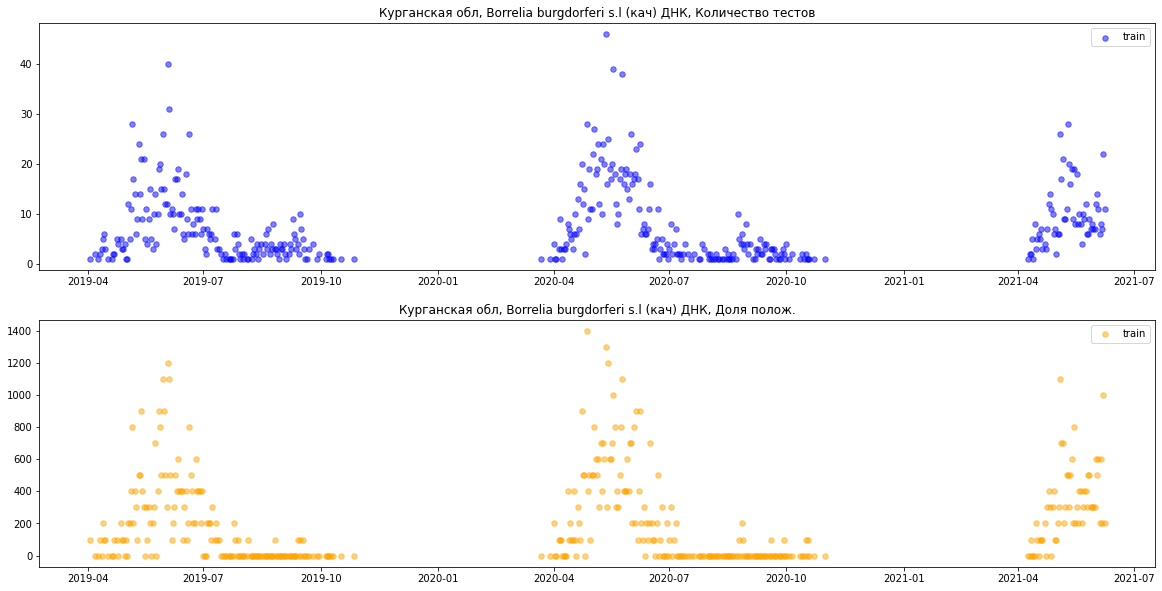

In [41]:
plot_virus_region_data("Курганская обл", "Borrelia burgdorferi s.l (кач) ДНК")

In [42]:
data_all.head()

,Имя теста,Регион,Количество тестов,Доля полож.,Дата,Регион_Длинное название,Регион_краткое название,Столица региона,Фед.Округ,Разница со временем по мск,Зарплата_2018,Зарплата_2019,Зарплата_2020,Признак эндемичности,Доступность ПЦР-диагностики,Население региона,Доля городского населения в общей численности населения на 1 января 2020 г.
0,Borrelia burgdorferi s.l (кач) ДНК,Челябинская обл,1,100.0,2019-05-25 08:02:00,Челябинская область,Челябинская обл.,Челябинск,УФО,2,97204,101012,111216,да,188.9,3493036,82.7
1,Borrelia burgdorferi s.l (кач) ДНК,Челябинская обл,1,100.0,2019-05-27 11:04:00,Челябинская область,Челябинская обл.,Челябинск,УФО,2,97204,101012,111216,да,188.9,3493036,82.7
2,Вирус клещевого энцефалита(кач) РНК,Челябинская обл,1,0.0,2019-05-27 11:04:00,Челябинская область,Челябинская обл.,Челябинск,УФО,2,97204,101012,111216,да,188.9,3493036,82.7
3,Borrelia burgdorferi s.l (кач) ДНК,Челябинская обл,1,100.0,2019-05-27 11:14:00,Челябинская область,Челябинская обл.,Челябинск,УФО,2,97204,101012,111216,да,188.9,3493036,82.7
4,Вирус клещевого энцефалита(кач) РНК,Челябинская обл,1,0.0,2019-05-27 11:14:00,Челябинская область,Челябинская обл.,Челябинск,УФО,2,97204,101012,111216,да,188.9,3493036,82.7


### Предсказания

In [43]:
regions = sorted(invitro_data_new['Регион'].unique())

columns = [
       'region',
       'Anaplasma Phagocytophillum(кач) ДНК count',
       'Anaplasma Phagocytophillum(кач) ДНК pos perc',
       'Borrelia burgdorferi s.l (кач) ДНК count',
       'Borrelia burgdorferi s.l (кач) ДНК pos perc',
       'Borrelia miyamotoi (кач) ДНК count',
       'Borrelia miyamotoi (кач) ДНК pos perc',
       'Ehrlichia muris/chaffeеnsis(кач) ДНК count',
       'Ehrlichia muris/chaffeеnsis(кач) ДНК pos perc',
       'Вирус клещевого энцефалита(кач) РНК count',
       'Вирус клещевого энцефалита(кач) РНК pos perc'
]

def get_empty_submission():
    
    # test date range 
    date = pd.date_range('2021.06.09', '2021.06.27', freq='1d')
    
    submission = pd.DataFrame()
    
    for region in regions:
        df_reg = pd.DataFrame(index=date, columns=columns)
        df_reg['region'] = region
        df_reg[columns[1:]] = 0.
        submission = submission.append(df_reg)
    return submission


def validate_submission(submission):
    if isinstance(submission, str):
        submission = pd.read_csv(submission, index_col=0)
        
    assert submission.shape == (1273, 11), 'invalid shape'
    
    assert np.array_equal(submission.columns, columns), 'invalid cols'
    assert submission.isnull().sum().sum() == 0, 'null values'
    assert (submission.iloc[:, 1:] < 0).sum().sum() == 0, 'negative values'
    print('validation success')

In [44]:
submission = get_empty_submission()
validate_submission(submission)

validation success


In [45]:
submission

,region,Anaplasma Phagocytophillum(кач) ДНК count,Anaplasma Phagocytophillum(кач) ДНК pos perc,Borrelia burgdorferi s.l (кач) ДНК count,Borrelia burgdorferi s.l (кач) ДНК pos perc,Borrelia miyamotoi (кач) ДНК count,Borrelia miyamotoi (кач) ДНК pos perc,Ehrlichia muris/chaffeеnsis(кач) ДНК count,Ehrlichia muris/chaffeеnsis(кач) ДНК pos perc,Вирус клещевого энцефалита(кач) РНК count,Вирус клещевого энцефалита(кач) РНК pos perc
2021-06-09,Адыгея Респ,0,0,0,0,0,0,0,0,0,0
2021-06-10,Адыгея Респ,0,0,0,0,0,0,0,0,0,0
2021-06-11,Адыгея Респ,0,0,0,0,0,0,0,0,0,0
2021-06-12,Адыгея Респ,0,0,0,0,0,0,0,0,0,0
2021-06-13,Адыгея Респ,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-23,Ярославская обл,0,0,0,0,0,0,0,0,0,0
2021-06-24,Ярославская обл,0,0,0,0,0,0,0,0,0,0
2021-06-25,Ярославская обл,0,0,0,0,0,0,0,0,0,0
2021-06-26,Ярославская обл,0,0,0,0,0,0,0,0,0,0


In [46]:
stat_numbers[stat_numbers == 1]

Регион                     Имя теста                           
Тульская обл               Ehrlichia muris/chaffeеnsis(кач) ДНК    1
                           Anaplasma Phagocytophillum(кач) ДНК     1
Кабардино-Балкарская Респ  Borrelia burgdorferi s.l (кач) ДНК      1
Чеченская Респ             Вирус клещевого энцефалита(кач) РНК     1
Кабардино-Балкарская Респ  Вирус клещевого энцефалита(кач) РНК     1
Ямало-Ненецкий АО          Borrelia burgdorferi s.l (кач) ДНК      1
                           Вирус клещевого энцефалита(кач) РНК     1
Чеченская Респ             Borrelia burgdorferi s.l (кач) ДНК      1
Московская область         Borrelia miyamotoi (кач) ДНК            1
Name: Количество, dtype: int64

In [47]:
sarimax_data = invitro_data_new.copy()

In [48]:
for region, virus in stat_numbers[stat_numbers == 1].index:
    sarimax_data = sarimax_data[(sarimax_data['Регион'] != region) |  (sarimax_data['Имя теста'] != virus)]

In [49]:
sarimax_data[(sarimax_data['Регион'] == 'Чеченская Респ') & (sarimax_data['Имя теста'] == 'Borrelia burgdorferi s.l (кач) ДНК')]

,Имя теста,Регион,Количество тестов,Доля полож.,Дата


In [50]:
def get_region_data(region, data):
    region_data = data[data["Регион"] == region]
    region_data = region_data.groupby([region_data["Дата"].dt.floor('d'), 'Имя теста']).sum()
    region_data = region_data.reset_index('Имя теста')
    return region_data

In [66]:
def get_predictions_sarimax(region_data):
    predictions = {}

    for  virus, virus_data in region_data.groupby('Имя теста'):

        # virus_data = virus_data.resample('d').mean()
        virus_data = virus_data.reindex(pd.date_range(virus_data.index.min(), end=datetime(2021, 6, 8), freq ='D'))
        virus_data = virus_data.fillna(0)

        dates_pred = pd.date_range(start=datetime(2021, 6, 9), end=datetime(2021, 6, 27))

        exog = pd.DataFrame(index=pd.date_range(virus_data.index.min(), datetime(2021, 6, 27), freq ='D'))
        exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
        exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)
        exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
        exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)
        exog_train = exog.iloc[: -len(dates_pred)]
        exog_test = exog.iloc[-len(dates_pred):]

        try:           
            model_counts = SARIMAX(
                virus_data["Количество тестов"],
                exog=exog_train,
                order=(0, 0, 1),
                seasonal_order=(1, 1, 1, 7),
                enforce_stationarity=False,
                enforce_invertibility=False,).fit()
            
            model_fraction = SARIMAX(
                virus_data["Доля полож."],
                exog=exog_train,
                order=(0, 0, 1),
                seasonal_order=(1, 1, 1, 7),
                enforce_stationarity=False,
                enforce_invertibility=False).fit()

            pred_count = model_counts.predict(start=datetime(2021, 6, 9), end=datetime(2021, 6, 27), exog=exog_test)
            pred_fraction = model_fraction.predict(start=datetime(2021, 6, 9), end=datetime(2021, 6, 27), exog=exog_test)

            predictions[f'{virus} count'] = pred_count
            predictions[f'{virus} pos perc'] = pred_fraction.clip(0, 100)
        
        except:
            dates_prev = pd.date_range(start=datetime(2021, 5, 19), end=datetime(2021, 6, 6))

            predictions[f'{virus} count'] = pd.Series(
                index=dates_pred.array,
                data=virus_data.loc[dates_prev.array]["Количество тестов"].values
                )
            predictions[f'{virus} pos perc'] = pd.Series(
                index=dates_pred.array,
                data=virus_data.loc[dates_prev.array]["Доля полож."].values
                )

    return predictions

In [75]:
def plot_predictions(region, region_data, predictions):
    n = len(predictions)
    plt.figure(figsize=(20, n * 10))

    for i, (virus, virus_data) in enumerate(region_data.groupby('Имя теста')):

        pred_count = predictions[f'{virus} count']
        pred_fraction = predictions[f'{virus} pos perc']

        plt.subplot(n * 2, 1, i * 2 + 1)
        plt.title(f"{region}, {virus}, Количество тестов")
        plt.scatter(virus_data.index, virus_data["Количество тестов"], label="train", c='b', alpha=0.5, s=30)
        plt.scatter(pred_count.index, pred_count, label="pred", c='black', marker='*', alpha=0.5, s=50)
        plt.legend()

        plt.subplot(n * 2, 1, i * 2 + 2)
        plt.title(f"{region}, {virus}, Доля полож.")
        plt.scatter(virus_data.index, virus_data["Доля полож."], label="train", c='orange', alpha=0.5, s=30)
        plt.scatter(pred_fraction.index, pred_fraction, label="pred", c='red', marker='*', alpha=0.5, s=50)
        plt.legend()

In [54]:
def plot_data(region, region_data):
    n = len(region_data['Имя теста'].unique())
    plt.figure(figsize=(20, n * 10))

    for i, (virus, virus_data) in enumerate(region_data.groupby('Имя теста')):

        plt.subplot(n * 2, 1, i * 2 + 1)
        plt.title(f"{region}, {virus}, Количество тестов")
        plt.scatter(virus_data.index, virus_data["Количество тестов"], label="train", c='b', alpha=0.5, s=10)
        plt.legend()

        plt.subplot(n * 2, 1, i * 2 + 2)
        plt.title(f"{region}, {virus}, Доля полож.")
        plt.scatter(virus_data.index, virus_data["Доля полож."], label="train", c='orange', alpha=0.5, s=10)
        plt.legend()

In [67]:
bad_regions = []
preditions_all = {}
for region in tqdm(regions):
    region_data = get_region_data(region, sarimax_data)
    try:
        preditions_all[region] = get_predictions_sarimax(region_data)
    except:
        print('-' * 30 + ' ' + region + ' ' + '-' * 30)
        bad_regions.append(region)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [56]:
bad_regions

[]

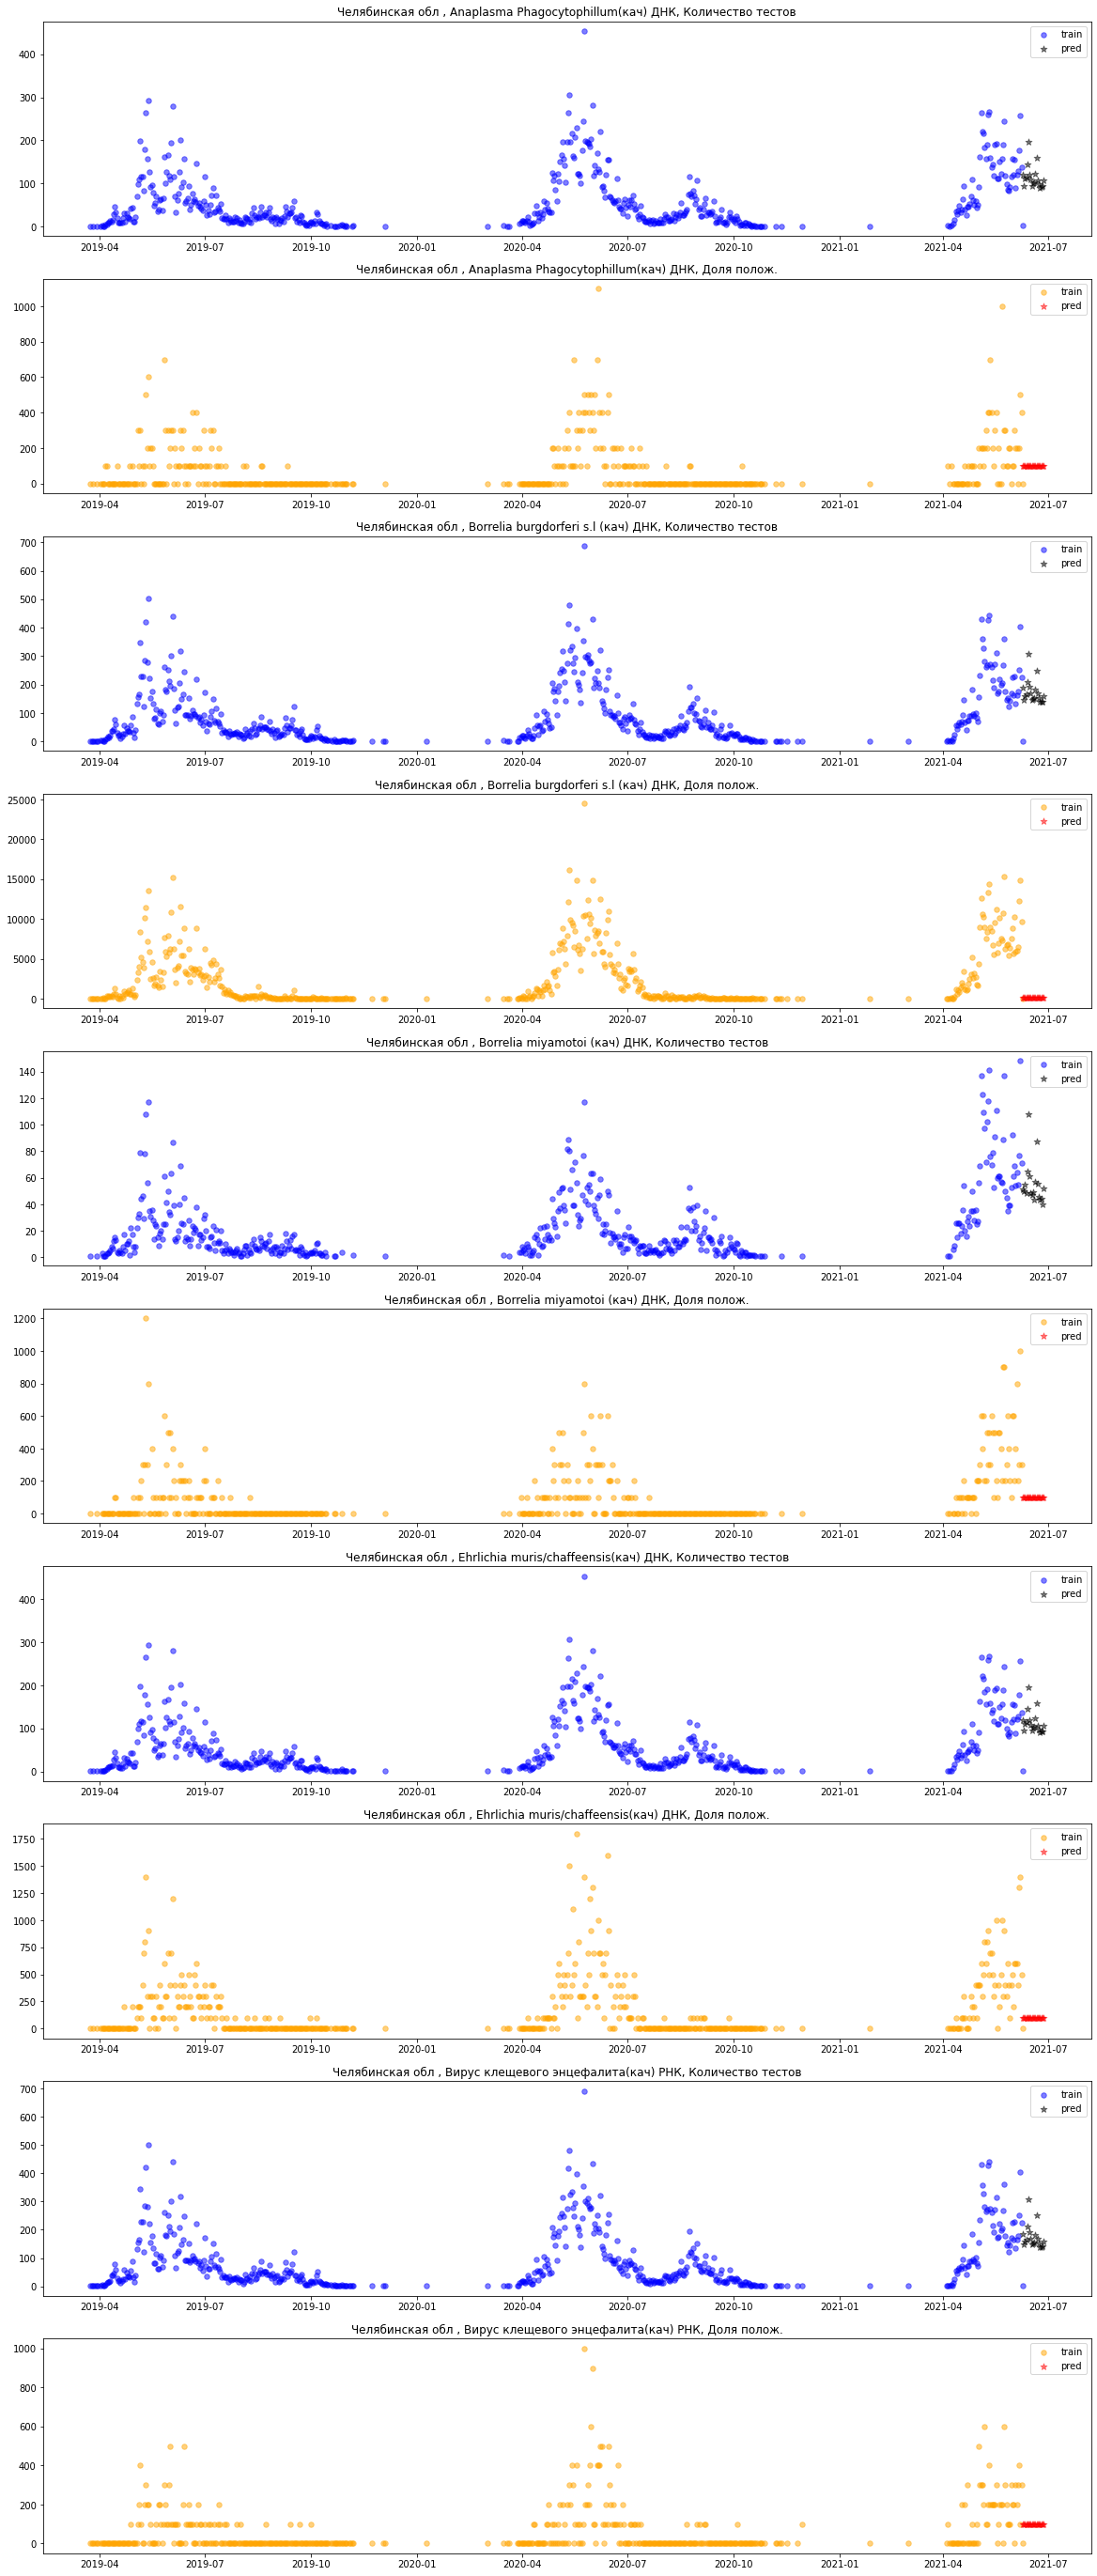

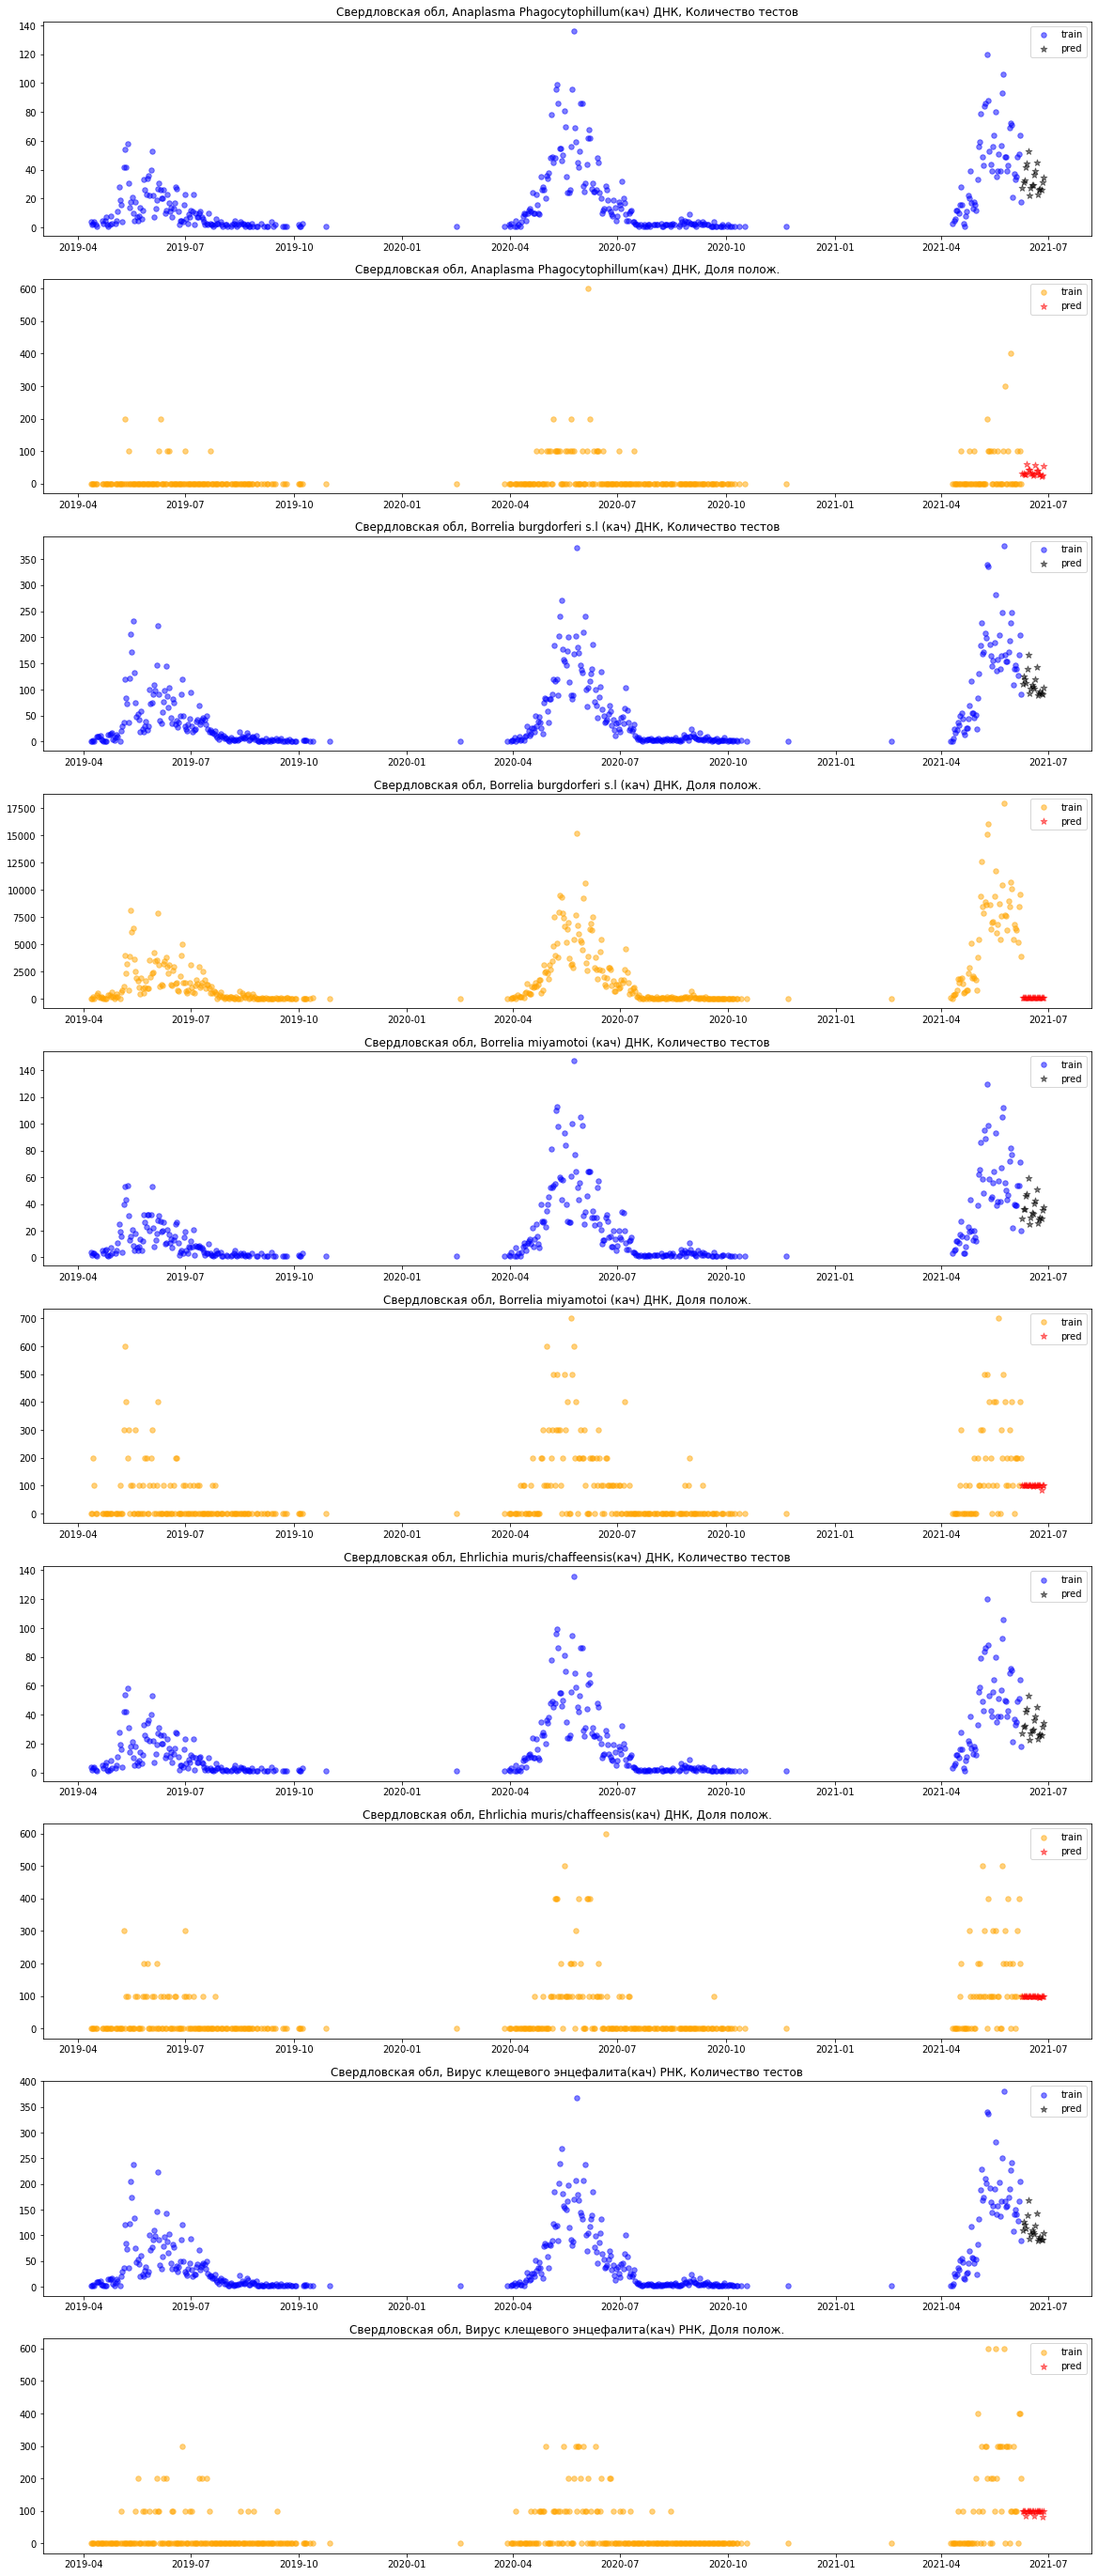

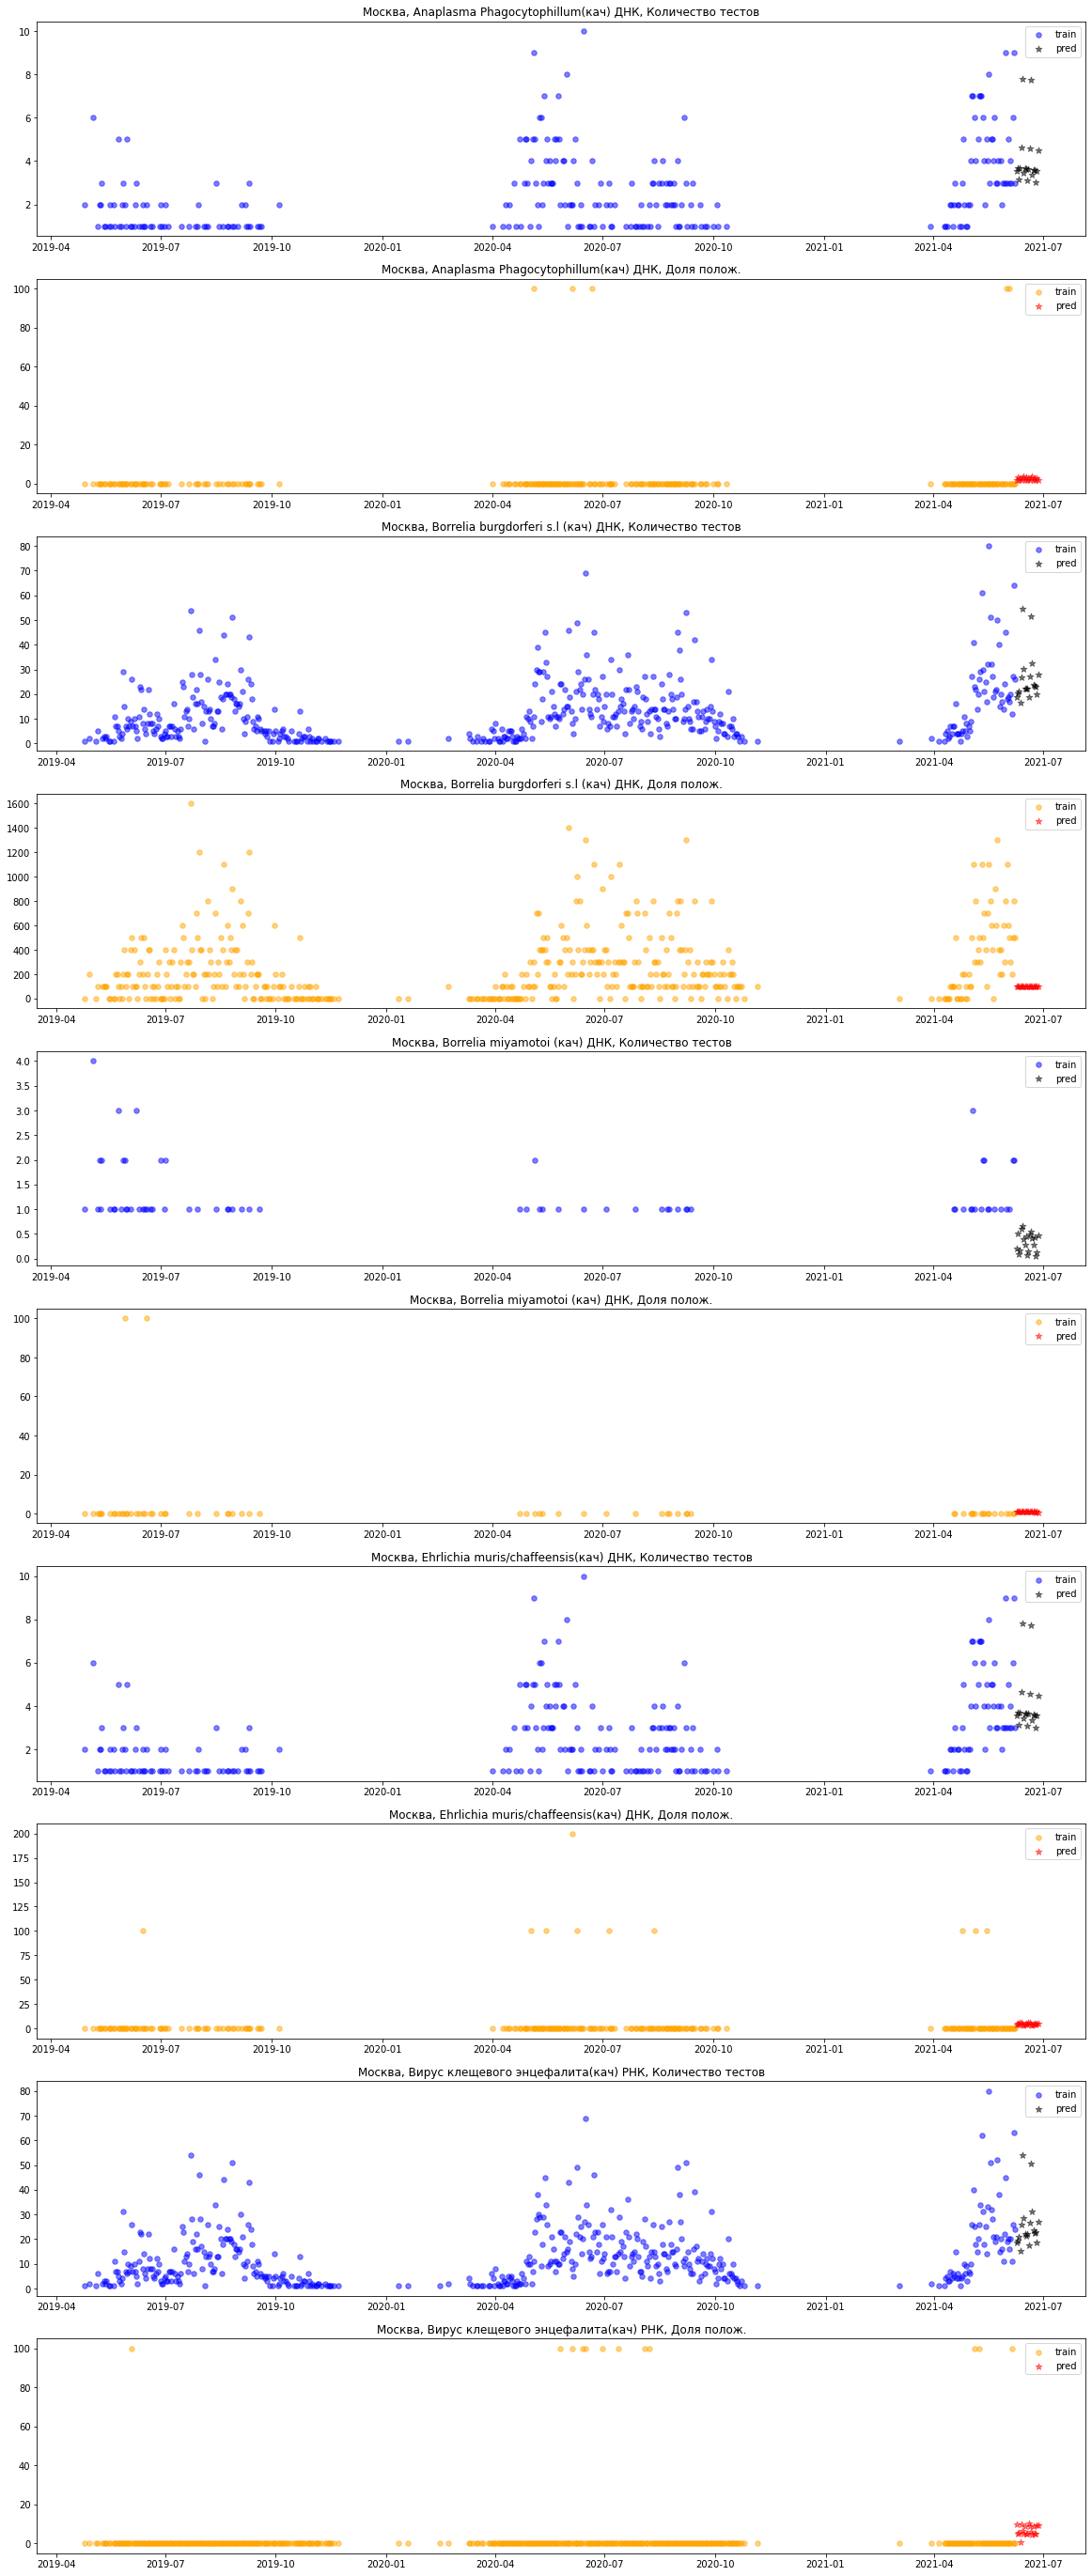

In [77]:
for region in ['Челябинская обл ', 'Свердловская обл', 'Москва']:
    region_data = get_region_data(region, sarimax_data)
    try:
        plot_predictions(region, region_data, preditions_all[region])
    except:
        continue

In [ ]:
submission

,region,Anaplasma Phagocytophillum(кач) ДНК count,Anaplasma Phagocytophillum(кач) ДНК pos perc,Borrelia burgdorferi s.l (кач) ДНК count,Borrelia burgdorferi s.l (кач) ДНК pos perc,Borrelia miyamotoi (кач) ДНК count,Borrelia miyamotoi (кач) ДНК pos perc,Ehrlichia muris/chaffeеnsis(кач) ДНК count,Ehrlichia muris/chaffeеnsis(кач) ДНК pos perc,Вирус клещевого энцефалита(кач) РНК count,Вирус клещевого энцефалита(кач) РНК pos perc
2021-06-09,Адыгея Респ,0,0,0,0,0,0,0,0,0,0
2021-06-10,Адыгея Респ,0,0,0,0,0,0,0,0,0,0
2021-06-11,Адыгея Респ,0,0,0,0,0,0,0,0,0,0
2021-06-12,Адыгея Респ,0,0,0,0,0,0,0,0,0,0
2021-06-13,Адыгея Респ,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-23,Ярославская обл,0,0,0,0,0,0,0,0,0,0
2021-06-24,Ярославская обл,0,0,0,0,0,0,0,0,0,0
2021-06-25,Ярославская обл,0,0,0,0,0,0,0,0,0,0
2021-06-26,Ярославская обл,0,0,0,0,0,0,0,0,0,0


In [69]:
for region in regions:
    for test in preditions_all[region]:
        data = preditions_all[region][test]
        submission.loc[submission.index[submission['region'] == region], test] = data

In [70]:
validate_submission(submission)

validation success


In [74]:
submission.to_csv("drive/MyDrive/HACKATHON/submission_v3.csv")

In [72]:
def get_MAE(region_data):
    errors = []

    for  virus, virus_data in region_data.groupby('Имя теста'):

        virus_data_future = virus_data.reindex(pd.date_range(start=datetime(2021, 6, 2), end=datetime(2021, 6, 8), freq ='D'))
        virus_data_future = virus_data_future.fillna(0)

        virus_data = virus_data.reindex(pd.date_range(virus_data.index.min(), end=datetime(2021, 6, 1), freq ='D'))
        virus_data = virus_data.fillna(0)

        dates_pred = pd.date_range(start=datetime(2021, 6, 2), end=datetime(2021, 6, 8))

        try:           
            model_counts = SARIMAX(
                virus_data["Количество тестов"],
                order=(0, 0, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False).fit()
            
            model_fraction = SARIMAX(
                virus_data["Доля полож."],
                order=(0, 0, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False).fit()

            pred_count = model_counts.predict(start=datetime(2021, 6, 2), end=datetime(2021, 6, 8))
            pred_fraction = model_fraction.predict(start=datetime(2021, 6, 2), end=datetime(2021, 6, 8))
        
        except:
            
            dates_prev = pd.date_range(start=datetime(2021, 5, 26), end=datetime(2021, 6, 1))

            pred_count = pd.Series(
                index=dates_pred.array,
                data=virus_data.loc[dates_prev.array]["Количество тестов"].values
                )
            pred_fraction = pd.Series(
                index=dates_pred.array,
                data=virus_data.loc[dates_prev.array]["Доля полож."].values
                )
            
        errors.append(np.abs(pred_count - virus_data_future.loc[dates_pred.array, "Количество тестов"]).sum() / len(dates_pred))
        errors.append(np.abs(pred_fraction - virus_data_future.loc[dates_pred.array, "Доля полож."]).sum() / len(dates_pred))

    return errors

In [73]:
errors = []
for region in tqdm(regions):
    region_data = get_region_data(region, sarimax_data)
    errors.extend(get_MAE(region_data))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [76]:
np.mean(errors)

39.27763733731715